In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
sns.set()

Пусть перед нами стоит задача: есть выборка, надо понять эта выборка сэмплирована из некоторого распределения P0, или нет. То есть мы проверяем    
- $H_0: \mathcal{P} = \mathcal{P}_0\ vs.\ H_1: \mathcal{P} \neq \mathcal{P}_0$.

Либо, есть задача проверки принадлежности истинного распределения некоторому классу распределений    
- $H_0: \mathcal{P} \in \{\mathcal{P}_{\theta}| \theta \in \Theta \}\ vs.\ H_1: \mathcal{P} \notin \{\mathcal{P}_{\theta}| \theta \in \Theta \}$

Критерий, проверяющий эти гипотезы, называется критерием согласия. Первая гипотеза называется простой, а вторая - сложной.
Для простой гипотезы существует критерий Колмогорова

Для этого рассмотрим эмпирическую функцию распределения, полученную с помощью нашей выборки    
$$\widehat{F_n}(x) = \frac{1}{n}\sum_i[X_i \leqslant x]$$

Приведём список её хороших свойств:   
1. $\widehat{F_n}(x) \overset{п.н.}{\to} F(x) \ \forall x \in \mathbb{R}$
2. $\mathbb{E}(\widehat{F_n}(x)) = F(x) $
3. $\mathbb{D}(\widehat{F_n}(x)) = \frac{1}{n} F(x)(1-F(x))$

Есть ещё теорема Гливенкко-Кантелли, училивающая первый факт и гарантирующая нам равномерную сходимость эмпирической ф.р. к истинной с вероятностью 1:   
- $\sup_{x \in \mathbb{R}} |F_n(x) - F(x)| \overset{\text{п.н.}}{\to} 0 \quad \text{при } n \to \infty$

И, самое важное для нас, теорема Колмогорова, которая уточняет скорость сходимости в теореме Гливенко-Кантелли для случайных величин с непрерывной функцией распределения, и, самое главное, описывает предельное распределение в явном виде:    
- $\sqrt{n}\sup_{x \in \mathbb{R}} |F_n(x) - F(x)| \overset{\text{d}}{\to} К \quad \text{при } n \to \infty$     

где K - с.в., имеющая распределение Колмогорова про которое можно прочитать по [ссылке](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%9A%D0%BE%D0%BB%D0%BC%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B2%D0%B0)

Эмпирически проверим теорему Гливенко-Кантелли

In [3]:
def calc_Fn(sample, x):
    """
        Функция строит эмпирическую функцию распределения по sample для Fn(x).
    """
    
    return np.mean(sample <= x)

In [4]:
def check_GK(dist, N, left=-5, right=5):
    sample = dist.rvs(N)
    Fn = np.empty(10_000)

    x = np.linspace(left, right, 10_000)
    for i in tqdm(range(10_000), leave=False):
        Fn[i] = calc_Fn(sample, x[i])

    sup = np.max(np.abs(Fn - dist.cdf(x)))

    fig, ax = plt.subplots()

    ax.set_title(f'Dn = {sup}')

    ax.plot(x, Fn, label=f'Fn(x) при n = {N}')
    ax.plot(x, dist.cdf(x), label='F(x)')
    ax.legend()

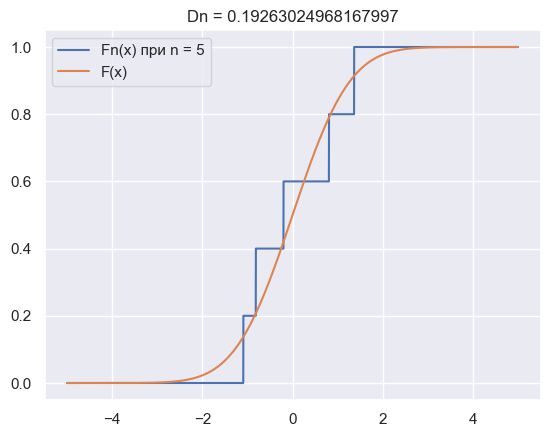

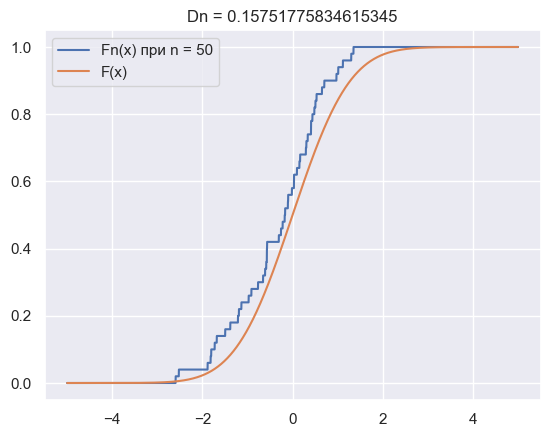

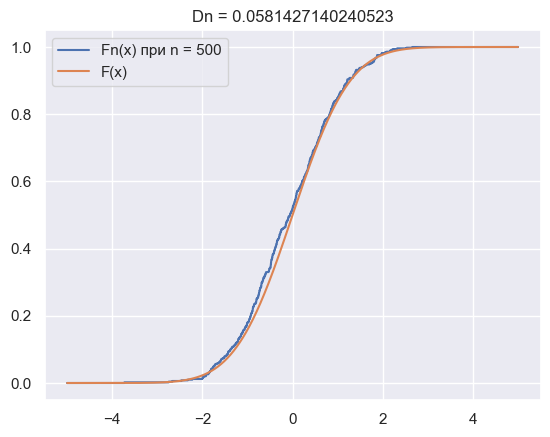

In [5]:
dist = stats.norm(loc=0, scale=1)
check_GK(dist, 5)
check_GK(dist, 50)
check_GK(dist, 500)

  0%|          | 0/10000 [00:00<?, ?it/s]

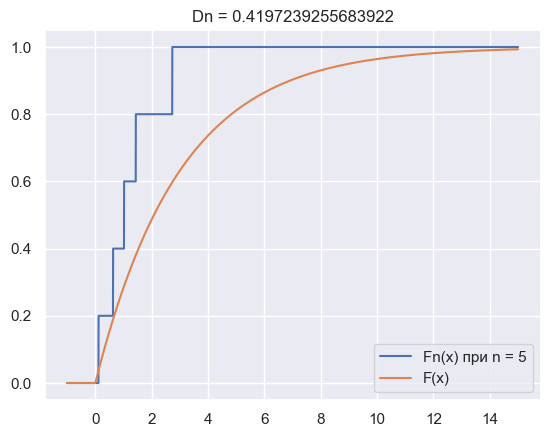

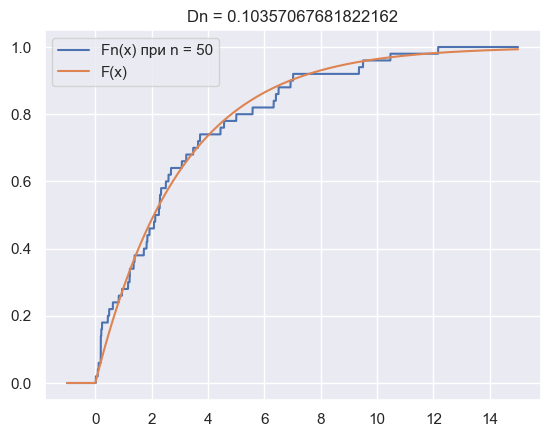

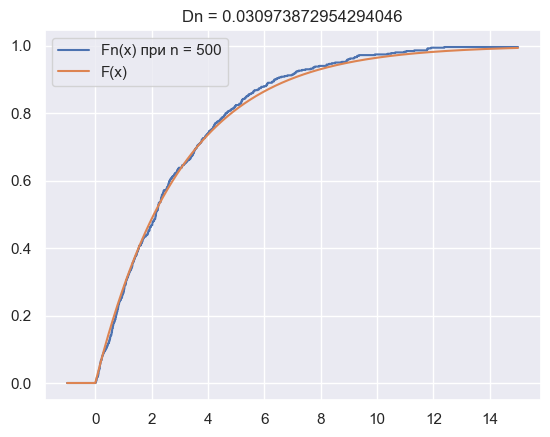

In [6]:
dist = stats.expon(scale=3)
check_GK(dist, 5, left=-1, right=15)
check_GK(dist, 50, left=-1, right=15)
check_GK(dist, 500, left=-1, right=15)

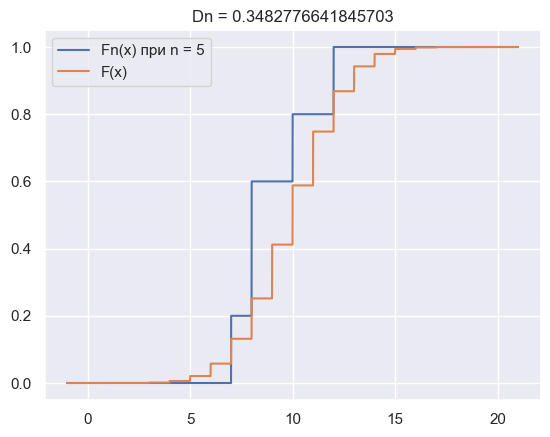

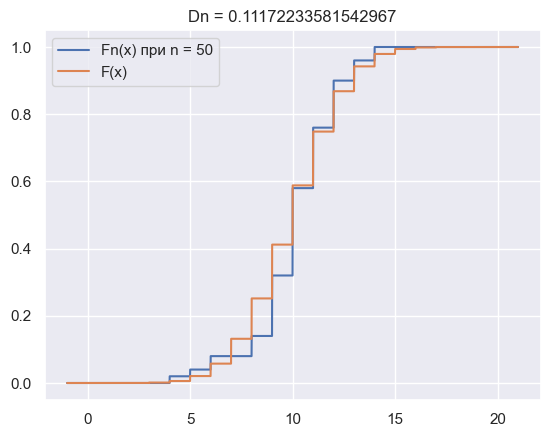

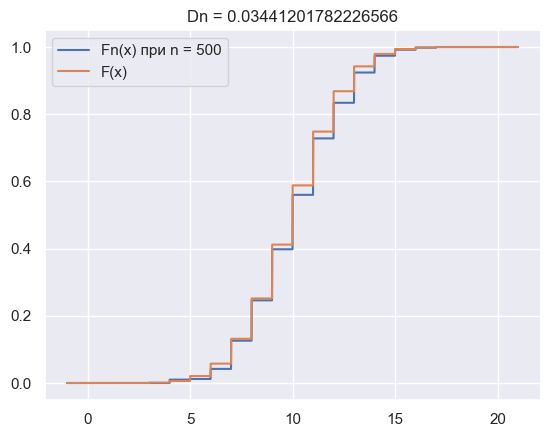

In [7]:
dist = stats.binom(n=20, p=0.5)
check_GK(dist, 5, left=-1, right=21)
check_GK(dist, 50, left=-1, right=21)
check_GK(dist, 500, left=-1, right=21)

Далее проверим теорему Колмогорова. Для этого заметим, что можно считать значение статистики $D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{F_n}(x) - F_0(x)|$ достаточно считать значение функции под модулём только в точках реализации выборки, где она принимает значения $\frac{k}{n}, k \in \mathbb{N}$, а тогда, для непрерывной ф.р., нужно вычислять $max(F(X_{(k)}) - \frac{k}{n}, F(X_{(k + 1)}) - \frac{k}{n})$ по всем $k=1...n$ (очень долго думаем, и понимаем, что это верно)

In [8]:
def get_D_statistic(sample, cdf_func):
    n = len(sample)
    sample.sort()

    Fn = np.linspace(0, 1, n + 1)
    F = cdf_func(sample)

    return max(np.max(np.abs(F - Fn[1:])), np.max(np.abs(F - Fn[:-1])))

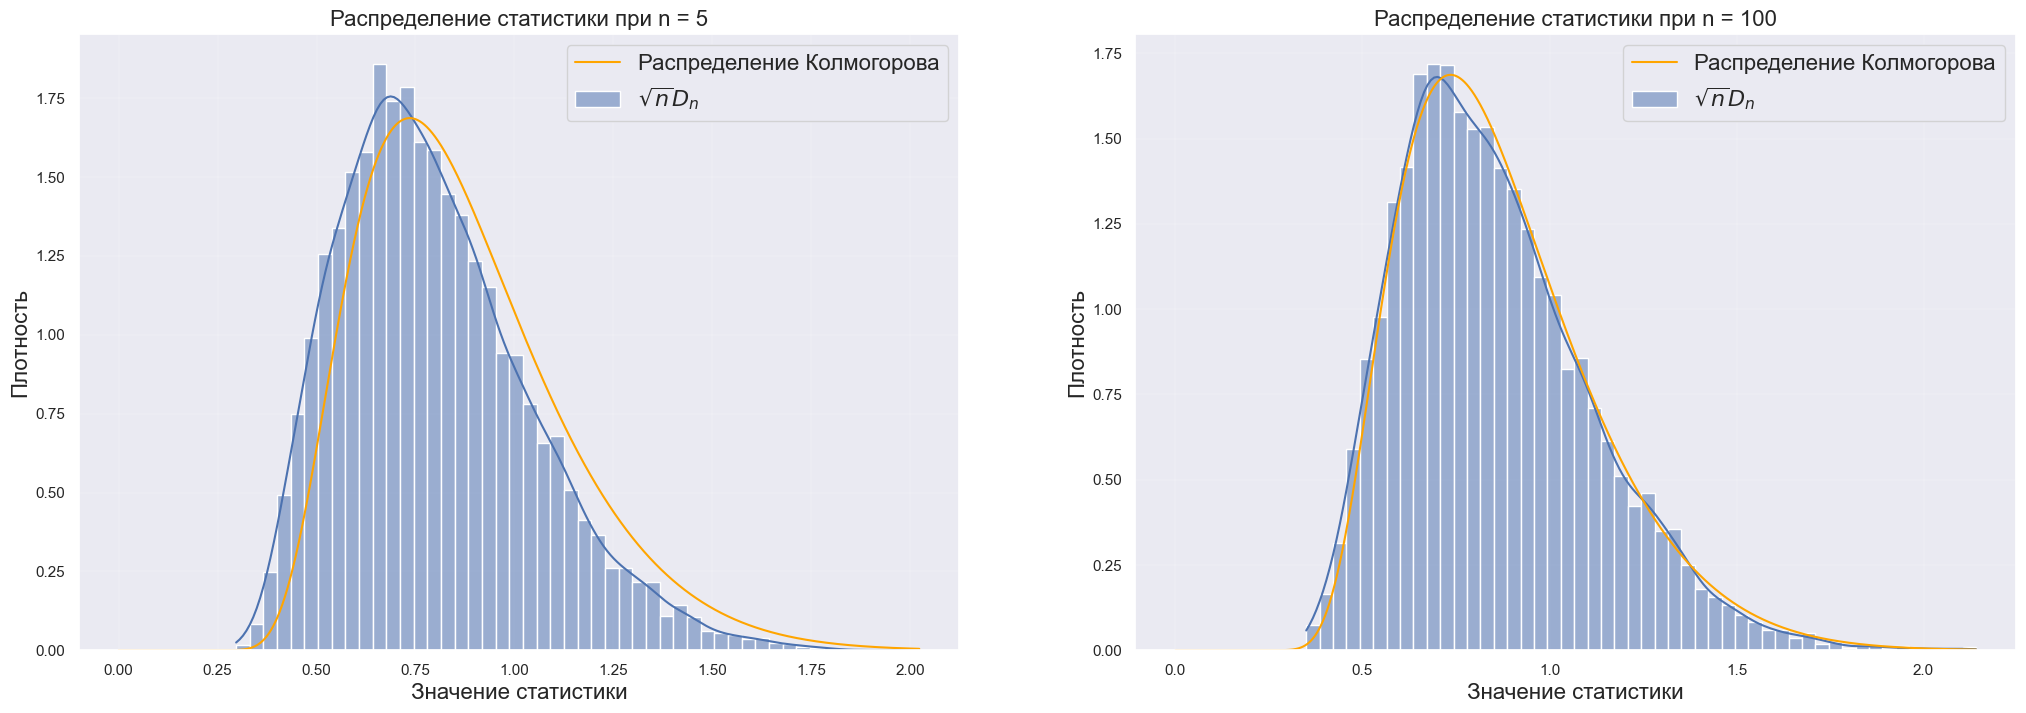

In [9]:
n_array = [5, 100]
dist = stats.expon()
N = 10_000

fig, ax = plt.subplots(1, len(n_array), figsize=(25, 8))

for ind, n in enumerate(n_array):
    stat = np.empty(N)

    for i in tqdm(range(N), leave=False):
        sample = dist.rvs(n)
        stat[i] = get_D_statistic(sample, dist.cdf) * np.sqrt(n)

    ax[ind].set_title(f'Распределение статистики при n = {n}', fontsize=16)

    x = np.linspace(0, np.max(stat), 10_000)
    sns.histplot(stat, ax=ax[ind], kde=True, stat='density', bins=50, label=r'$\sqrt{n}D_n$')
    ax[ind].plot(x, stats.kstwobign.pdf(x), label='Распределение Колмогорова', color='orange')
    ax[ind].legend(fontsize=16)
    ax[ind].grid(linewidth=0.2)
    ax[ind].set_xlabel('Значение статистики', fontsize=16)
    ax[ind].set_ylabel('Плотность', fontsize=16)



Теперь, вооружившись теоремой Колмогорова, можно составить критерий Колмогорова для решения задачи в случае, когда функция распределения $F_0$ является непрерывной 
- **Критерий Колмогорова**   
$H_0: F=F_0\ vs.\ H_1: F \neq F_0$   
- Статистика критерия - $D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{F_n}(x) - F_0(x)|$   
- При достаточно большом размере выборки $\sqrt{n} D_n \sim \phi$, где $\phi$ имеет распределение Колмогорова    
- критерий: $\left\{\sqrt{n} D_n \geq u_{1 - \alpha} \right\}$, где $u_{1 - \alpha}$ &mdash; $1 - \alpha$ квантиль распределения Колмогорова
    - `p-value = 1 - kstwobign.cdf(d)`, где d &mdash; реализация статистики $\sqrt{n}D(X)$, `kstwobign` &mdash; функция распределения Колмогорова.

**Критерий уже реализован в библиотеке stats**
- `scipy.stats.kstest`

In [10]:
sample = stats.norm(0.1, 0.04).rvs(10)

Dn, p = stats.kstest(rvs=sample, cdf='norm', args=(0.1, 0.04))
print(f'p-value: {p:.4f}')

p-value: 0.3983


In [11]:
Dn, p = stats.kstest(rvs=sample, cdf=lambda x: stats.norm.cdf(x, loc=0.10, scale=0.04))
print(f'p-value: {p:.4f}')

p-value: 0.3983


In [12]:
def norm_cdf_closure(loc, scale):
    """Можно самостоятельно написать функцию"""
    def inner_norm_cdf(x):
        return stats.norm.cdf(x=x, loc=loc, scale=scale)
    return inner_norm_cdf

# вместо 'norm' можно в явном виде указать любую функцию распределения
Dn, p = stats.kstest(sample, norm_cdf_closure(loc=0.10, scale=0.04))
print(f'p-value: {p:.4f}')

p-value: 0.3983


**Проверим критерий** с помощью метода Монте-Карло

In [13]:
from statsmodels.stats.proportion import proportion_confint

In [14]:
def check_ktest(dist, sample_size, N_exps=10_000):
    bad_cnt = 0
    alpha = 0.05
    for i in tqdm(range(N_exps)):
        sample = dist.rvs(sample_size)
        pvalue = stats.kstest(sample, cdf=dist.cdf).pvalue
        if pvalue < 0.05:
            bad_cnt += 1
        
    print(f'FPR = {round(bad_cnt / N_exps, 4)}')
    print(f'CI = {proportion_confint(count=bad_cnt, nobs=N_exps, alpha=alpha, method='wilson')}')

In [15]:
check_ktest(stats.norm(loc=3, scale=1), sample_size=5)

100%|██████████| 10000/10000 [00:06<00:00, 1474.17it/s]

FPR = 0.05
CI = (0.04589848269058477, 0.05444711584302416)


In [16]:
check_ktest(stats.norm(loc=3, scale=1), sample_size=100)

100%|██████████| 10000/10000 [00:16<00:00, 592.88it/s]


FPR = 0.0543
CI = (0.05002725475432684, 0.05891504139329427)


In [17]:
check_ktest(stats.expon(loc=4), sample_size=20)

100%|██████████| 10000/10000 [00:09<00:00, 1063.18it/s]

FPR = 0.0473
CI = (0.04331039683565242, 0.05163727528915815)


Теперь можем убедиться, что для дискретных распределений критерий не работает

In [18]:
check_ktest(stats.binom(n=30, p=0.5), sample_size=100)

100%|██████████| 10000/10000 [00:27<00:00, 369.04it/s]

FPR = 0.7635
CI = (0.7550712741801565, 0.7717263586784967)


In [19]:
check_ktest(stats.binom(n=30, p=0.8), sample_size=100)

100%|██████████| 10000/10000 [00:20<00:00, 486.95it/s]

FPR = 0.9296
CI = (0.9244193048801211, 0.9344507637197935)


In [20]:
check_ktest(stats.randint(1, 7), sample_size=100)

100%|██████████| 10000/10000 [00:19<00:00, 516.17it/s]

FPR = 1.0
CI = (0.9996160016293234, 1.0)


In [21]:
check_ktest(stats.randint(0, 2), sample_size=100)

100%|██████████| 10000/10000 [00:07<00:00, 1390.46it/s]

FPR = 1.0
CI = (0.9996160016293234, 1.0)


**Проверка сложных гипотез**

> 📈 **Задача**
>
> Мы нашли в интернете доказательство, что отношение 2 независимых случайных величин из разных нормальных распределений &mdash; это нормальное распределение, в случае, если знаменатель "маловероятно будет близ 0" ([ссылка](https://link.springer.com/article/10.1007/s00362-012-0429-2)). Как это проверить на практике? 

**Идея**
- Насимулируем выборку отношений большого размера.
- На этой выборке проверим гипотезу $H_0:$ выборка из нормального распределения.
- Так мы проверим работоспособность критерия на каком-то случайном примере.


**"Критерий Колмогорова" для проверки сложных гипотез про нормальное распределение**


Но как проверить сложную гипотезу? Первая идея: давайте оценим параметры $\mu, \sigma^2$ по выборке. Похожее мы делали в t-test и там это сработало.
- $\widehat{\mu} = \overline X$
- $\widehat{\sigma^2} =S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$

In [22]:
def estimated_params_kstest(sample):
    mu = np.mean(sample)
    sigma = np.std(sample, ddof=1)
    dist = stats.norm(loc=mu, scale=sigma)
    return stats.kstest(sample, cdf=dist.cdf).pvalue

Проверим критерий с помощью Монте-Карло


In [46]:
def check_criterion(criterion, sample_size, N_exps=10000):
    """
        Функция для проверки придуманного критерия
        Возвращает доверительный интервал для FPR
    """
    bad_cnt=0
    alpha=0.05

    for i in tqdm(range(N_exps)):
        sample = stats.norm(loc=5, scale=3).rvs(sample_size)
        pvalue = criterion(sample)
        bad_cnt += (pvalue < alpha)

    print(f"FPR: {round(bad_cnt / N_exps, 4)}")
    print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=alpha, method='wilson')}")

In [24]:
check_criterion(estimated_params_kstest, sample_size=5)

100%|██████████| 10000/10000 [00:21<00:00, 470.70it/s]

FPR: 0.0
CI=(0.0, 0.0003839983706765959)


In [25]:
check_criterion(estimated_params_kstest, sample_size=100)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:25<00:00, 390.01it/s]

FPR: 0.0
CI=(0.0, 0.0003839983706765959)


FPR близок к нулю, а значит критерий очень плох - он слишком похож на тривиальный критерий, который, как мы помним, имеет очень плохую мощность, и использовать его не имеет смысла

Посмотрим на его мощность

In [68]:
def check_criterion_pow(criterion, sample_size, N_exps=10000):
    """
        Функция для проверки придуманного критерия
        Возвращает доверительный интервал для FNR
    """
    good_cnt=0
    alpha=0.05

    for i in tqdm(range(N_exps)):
        sample = stats.gamma(a=10).rvs(sample_size)
        pvalue = criterion(sample)
        good_cnt += (pvalue <= alpha)

    print(f"FNR: {round(good_cnt / N_exps, 4)}")
    print(f"CI={proportion_confint(count = good_cnt, nobs = N_exps, alpha=alpha, method='wilson')}")

In [69]:
check_criterion_pow(estimated_params_kstest, sample_size=5)

100%|██████████| 10000/10000 [00:24<00:00, 401.31it/s]

FNR: 0.0
CI=(0.0, 0.0003839983706765959)


In [70]:
check_criterion_pow(estimated_params_kstest, sample_size=100)

100%|██████████| 10000/10000 [00:34<00:00, 289.33it/s]

FNR: 0.0115
CI=(0.009589873754053872, 0.013785292654097161)


Такой результат обосновывается следующим образом - выборочные среднее и дисперсия специально подобраны так, чтобы хорошо объяснять нашу выборку, и они отличаются от истинного значения. Именно это отличие в случае простой задачи делал FPR большим, чем полученное выше

In [26]:
sample = stats.norm(loc=100, scale=10).rvs(1000)
mu = np.mean(sample)
sigma = np.std(sample, ddof=1)
mu, sigma

(99.82885576400027, 10.222731998951623)

В общем, можно сделать вывод, что  на самом деле статистика $\sqrt{n}D_n$ на самом деле имеет не распределение Колмогорова, а какое-то другое. Оно уже было найдено эмпирически, и критерий, использующий это распределение, называется **критерием Колмогорова с поправкой Лиллиефорса**

100%|██████████| 10000/10000 [00:15<00:00, 651.65it/s]


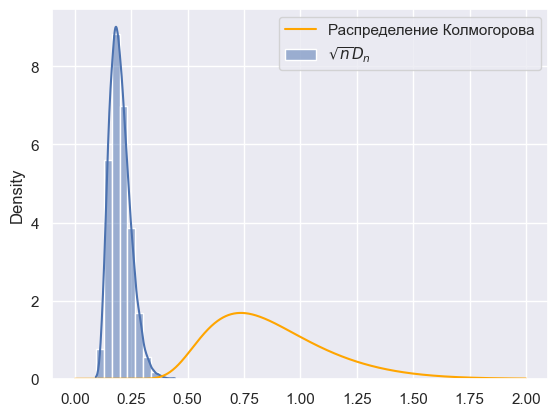

In [27]:
stat = np.empty(10_000)
for i in tqdm(range(10_000)):
    sample = stats.norm(loc=5, scale=3).rvs(1000)
    mu = np.mean(sample)
    sigma = np.std(sample, ddof=1)
    stat[i] = np.sqrt(n) * get_D_statistic(sample, stats.norm(loc=mu, scale=sigma).cdf)

fig, ax = plt.subplots()

sns.histplot(stat, ax=ax, kde=True, stat="density", bins=10, label=r'$\sqrt{n}D_n$')

x = np.linspace(0, 2, 1000)
ax.plot(x, stats.kstwobign.pdf(x), label='Распределение Колмогорова', color='orange')

ax.legend()

Этот критерий реализован в библиотеке statsmodels   
- [statsmodels.stats.diagnostic.lilliefors](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.lilliefors.html) — Критерий Лиллиефорса. 

In [28]:
from statsmodels.stats.diagnostic import lilliefors

In [29]:
Dn, p = lilliefors(stats.norm(loc=5, scale=3).rvs(1000), dist='norm', pvalmethod='table')
print(f'Kolmogorov-Lilliefors Dn statistic: {Dn:.4f},\np-value: {p:.4f}')

Kolmogorov-Lilliefors Dn statistic: 0.0167,
p-value: 0.7799


Проверим критерий

In [30]:
lilliefors_crit = lambda sample: lilliefors(sample, dist='norm')[1]
check_criterion(lilliefors_crit, sample_size=1000)

100%|██████████| 10000/10000 [00:13<00:00, 728.57it/s]

FPR: 0.0378
CI=(0.03423609837226937, 0.04171886972158407)


Решим теперь науш задачу с помощью этого метода

In [31]:
N = 10_000
sample = stats.norm(loc=200, scale=30).rvs(N) / stats.norm(loc=500, scale=5).rvs(N)

Dn, p = lilliefors(sample, dist='norm', pvalmethod='table')
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.0084,
p-value: 0.0846


In [32]:
N = 10_000
sample = stats.norm(loc=200, scale=30).rvs(N) / stats.norm(loc=50, scale=10).rvs(N)

Dn, p = lilliefors(sample, dist='norm', pvalmethod='table')
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.0749,
p-value: 0.0010


Мы решили задачу: если с.в. в знаменателе далека от  0, частное будет нормальным, иначе оно не нормальное

Для решения сложной задаче с нормальным распределением так же придуман **критерий Шапиро-Уилка** 
- `scipy.stats.shapiro` &mdash; [реализация в Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [33]:
shapiro_criterion = lambda sample: stats.shapiro(sample).pvalue
check_criterion(shapiro_criterion, sample_size=1000)

100%|██████████| 10000/10000 [00:09<00:00, 1067.88it/s]

FPR: 0.0484
CI=(0.044364369328904134, 0.052782457999490946)


In [34]:
N = 5000
sample = stats.norm(loc=200, scale=30).rvs(N) / stats.norm(loc=500, scale=10).rvs(N)

Dn, p = stats.shapiro(sample)
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.9998,
p-value: 0.9543


In [35]:
N = 5000
sample = stats.norm(loc=200, scale=30).rvs(N) / stats.norm(loc=20, scale=10).rvs(N)

Dn, p = stats.shapiro(sample)
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.0167,
p-value: 0.0000


Ещё один способ решения сложной задачи с нормальным распределением - **Q-Q plot**

Предположим, что у нас есть два нормальных распределения $\mathcal{N}(\mu, \sigma^2)$ и $\mathcal{N}(\mu', \sigma'^2)$. Идея метода основывается на следующем свойстве квантилей нормального распределения $$\frac {Q_{\beta}-Q_{\alpha}}{Q'_{\beta}-Q'_{\alpha}} =\frac{\sigma}{\sigma'}$$ где $Q_{\alpha}$ и $Q_{\beta}$ - квантили $\mathcal{N}(\mu, \sigma^2)$, $Q^{'}_{\alpha}$ и $Q^{'}_{\beta}$ - квантили $\mathcal{N}(\mu', \sigma'^2)$

Тогда становится ясно, что пары точек $(Q_{\alpha}, Q'_{\alpha})$ и $(Q_{\beta}, Q'_{\beta})$ лежат на одной прямой, из этого свойства возникает следующий способ визуализации близости выборки к нормальной

- Пусть у нас N точек в выборке.
- Тогда оценка i-ой квантили &mdash; i значение в отсортированной выборке (вспоминаем эмпирическую функцию распределения из 1 части - $\widehat{F_n}(x) = \dfrac{1}{N}\sum([X_i \leq x])$)
- Построим квантили стандартного нормального распределения.
    - Для этого посчитаем квантиль в каждой точке $\dfrac{i}{N},\ i \in \{1, ...\ N - 1\}$
- Отложим оценки квантилей первого распределения по оси Y, а истинные квантили второго распределения - по оси X.
- Если график напоминает прямую, значит считаем, что это нормальное распределение.


In [36]:
def my_qq_plot(sample):
    """
        Функция для отрисовки QQ-Plot.
    """
    
    sample.sort()
    sample_quantiles = sample[1:-1]
    N = len(sample)

    x = [i / N for i in range(1, N - 1)]
    theoretical_quantiles = stats.norm().ppf(x)
    
    # Визуализация
    fig, ax = plt.subplots(figsize=(18, 8))

    ax.plot(theoretical_quantiles, sample_quantiles, linestyle=':', linewidth=2.0, color='green')

    ax.set_xlabel('theoretical quantiles', fontsize=15)
    ax.set_ylabel('sample quantiles', fontsize=15)
    ax.set_title('QQ-Plot для выборки из нормального распределения', fontsize=15)

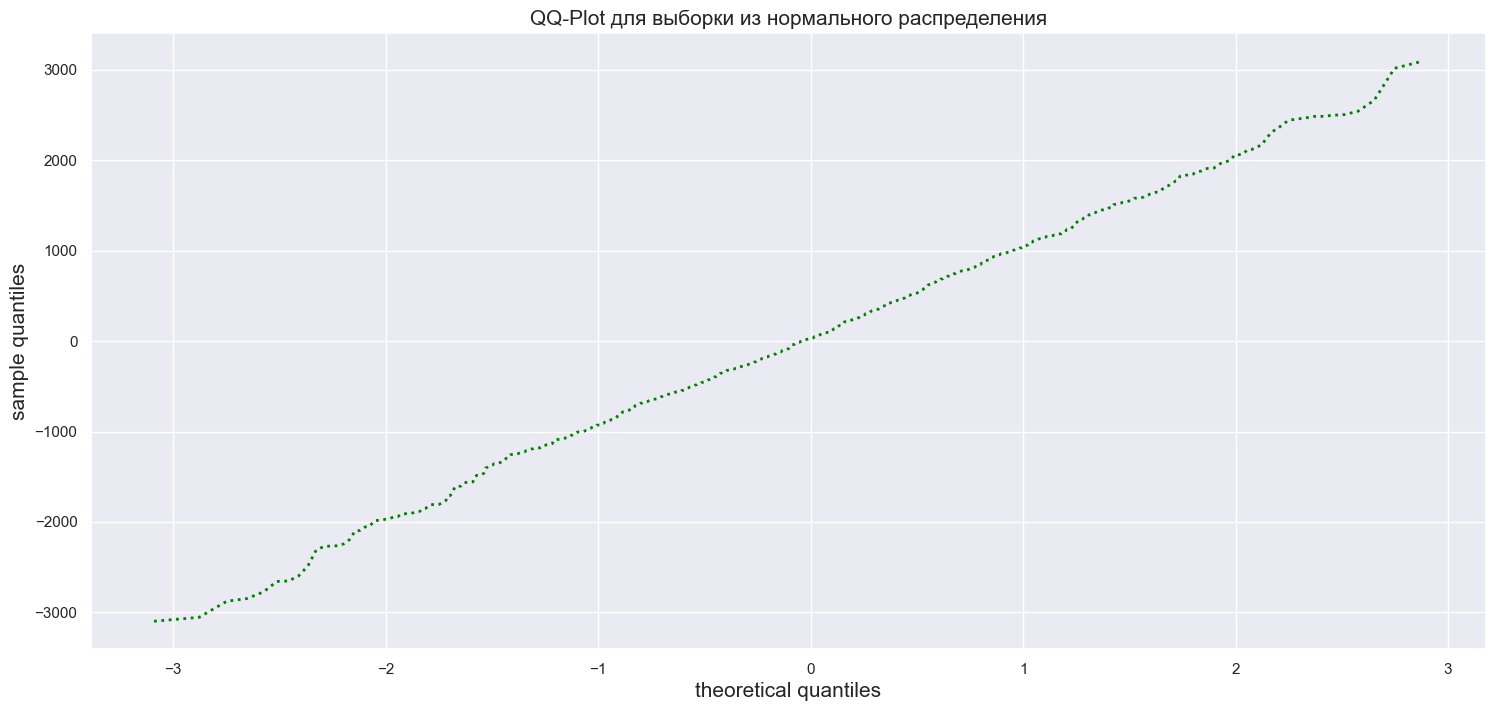

In [37]:
sample = stats.norm(loc=100, scale=1000).rvs(size=1000)
my_qq_plot(sample)

Можем визуально убедиться, что при большом числе степеней свободны распределение Стьюдента действительно очень похоже на нормальное

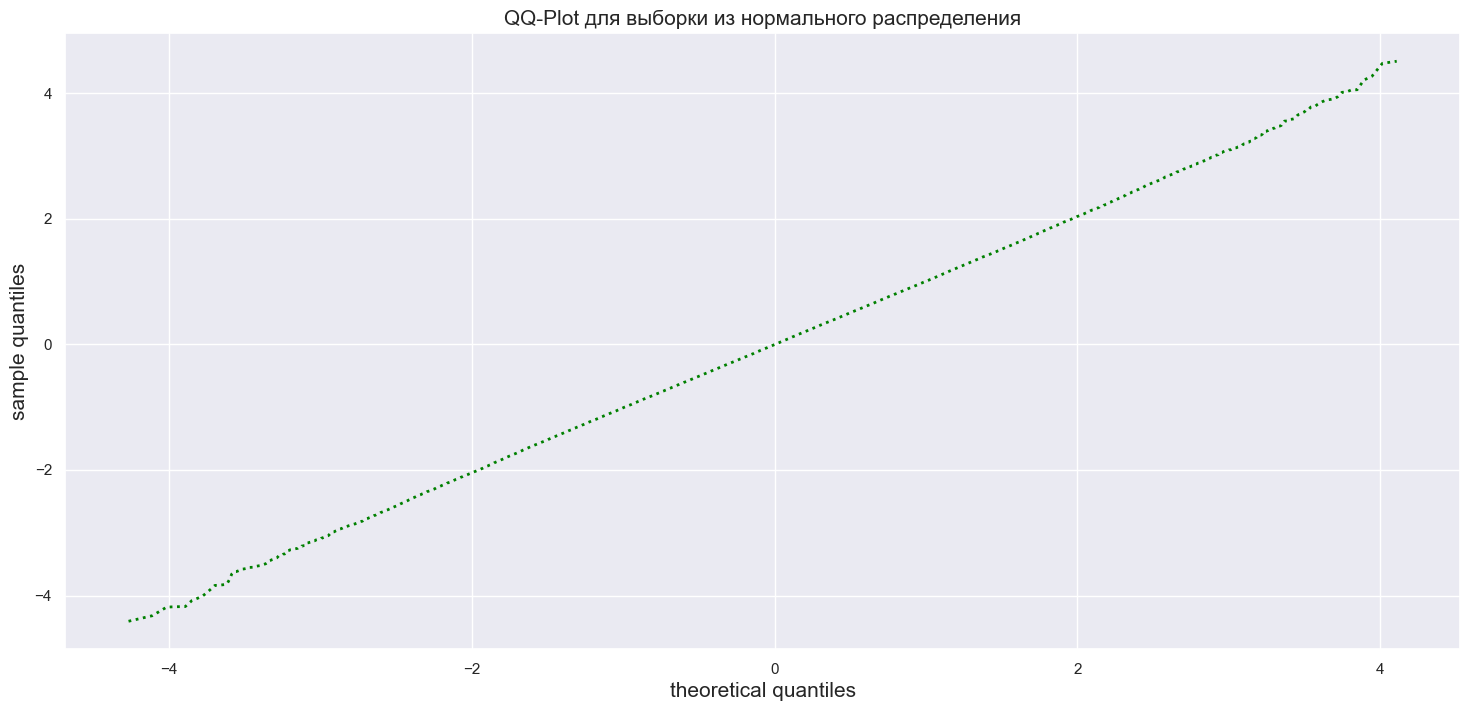

In [38]:
sample = stats.t(df=60).rvs(size=100000)
my_qq_plot(sample)

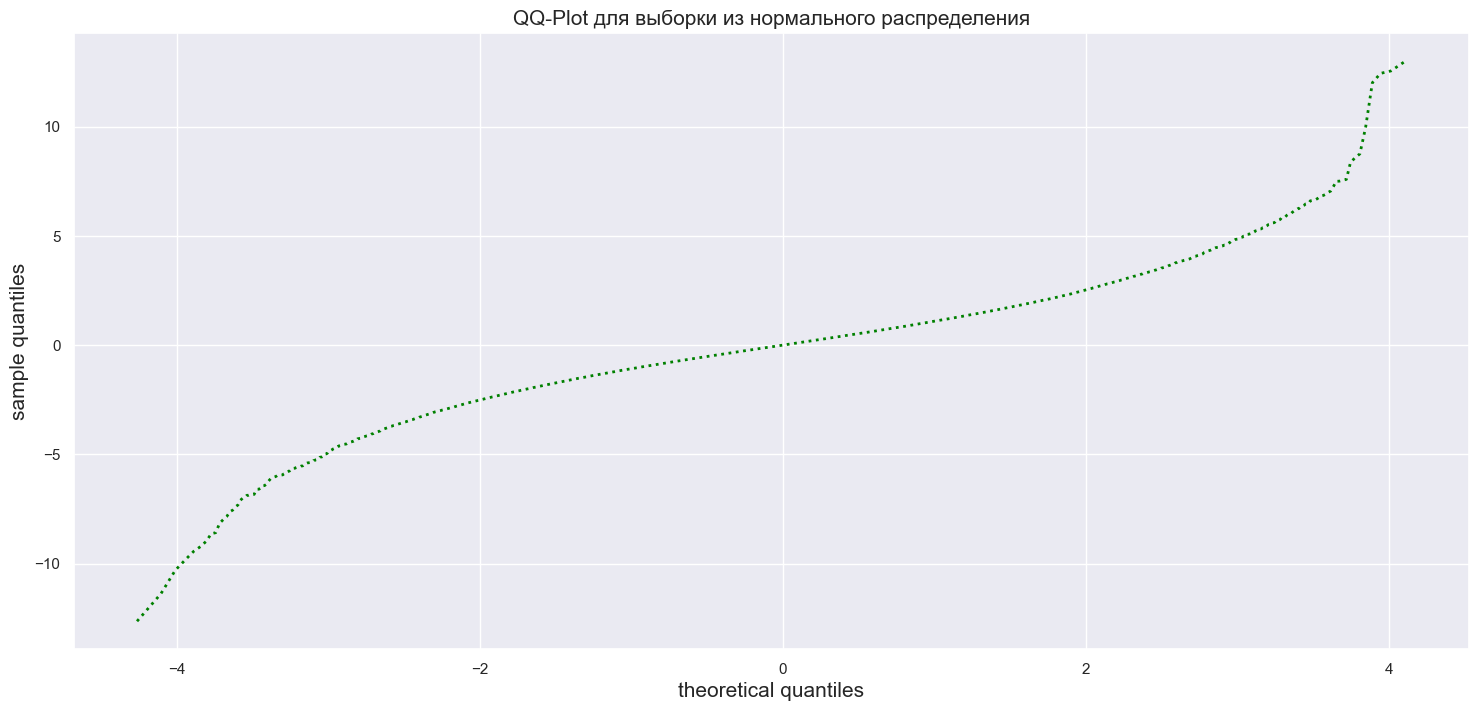

In [39]:
sample = stats.t(df=6).rvs(size=100000)
my_qq_plot(sample)

QQ-plot реализован в библиотеке statsmodels

In [40]:
from statsmodels.graphics.gofplots import qqplot

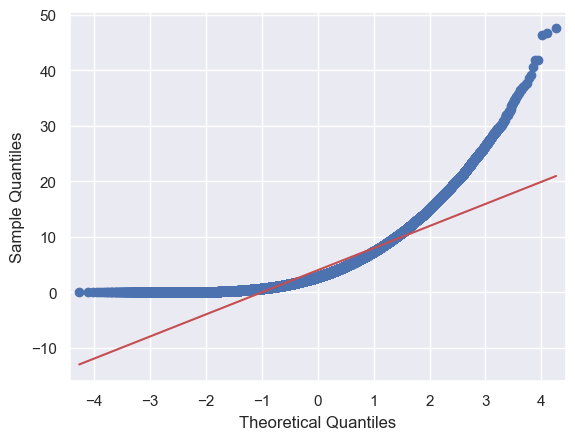

In [41]:
fig = qqplot(data=stats.expon(scale=4).rvs(100000), line='s', fit=False)
plt.show()

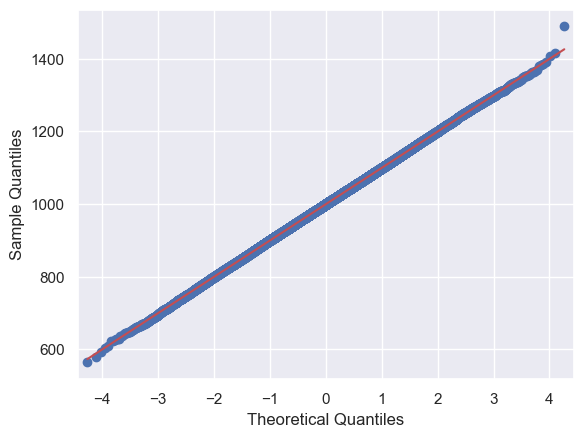

In [42]:
fig = qqplot(data=stats.norm(loc=1000, scale=100).rvs(100000), line='s', fit=False)
plt.show()

Этот способ нельзя назвать критерием, потому что у нас нет правила, при котором мы отвергаем нулевую гипотезу, но такая визуализация всё-равно может быть полезна

Далее обсудим применимость критерия согласия для использования данных в t-test

Как известно из математических теорем, да и из проверки в лекции, посвящённой Монте-Карло, нормальность данных не требуется для проведения t-test'а. Давайте ещё раз убедимся в этом, прогоняя данные через критерии Шапиро-Уилка, и если он отрицает нормальность, прогоняя их через t-test

In [43]:
N_exps = 10000
sample_size = 1000
bad_cnt=0
alpha=0.05

dist = stats.gamma(10)
sz = 0

for i in tqdm(range(N_exps)):
    # Генерирую выборку
    sample = dist.rvs(sample_size)

    # Проверяем выборку на нормальность
    if stats.shapiro(sample).pvalue > 0.05:
        continue
        
    # Мы попали сюда только тогда, когда отвергся критерий о нормальности данных
    # Запускаю критерий и считаю p-value
    pvalue = stats.ttest_1samp(sample, popmean=dist.mean()).pvalue

    # Проверяю, что pvalue < alpha
    bad_cnt += (pvalue < alpha)
    sz += 1

print(f"Процент отвержений данных на нормальность:  {round(sz/N_exps * 100, 0)}%")
print(f"FPR: {round(bad_cnt / sz, 4)}")
print(f"CI={proportion_confint(count = bad_cnt, nobs = sz, alpha=0.05, method='wilson')}")

100%|██████████| 10000/10000 [00:18<00:00, 537.72it/s]

Процент отвержений данных на нормальность:  100.0%
FPR: 0.0507
CI=(0.04657004046983549, 0.055175020466054485)


Видим, что критерий отвергает нормальность, но t-test всё ещё работает

А что если выборка маленькая? Конечно, нужно провести проверку с помощью метода Монте-Карло, но что если нет такой возможности? Поможет ли тут критерий согласия? Проверим это, в этот раз будем проводить t-test только если критерий Шапиро подтвердил нормальность, сделаем это для экспоненциальной выборки, для которой, как мы помним, приближение Стьюдентом работает довольно плохо

In [44]:
N_exps = 10000
sample_size = 5
bad_cnt=0
alpha=0.05

dist = stats.expon(scale=1/2)
sz = 0

for i in tqdm(range(N_exps)):
    # Генерирую выборку
    sample = dist.rvs(sample_size)

    # Проверяем выборку на нормальность
    if stats.shapiro(sample).pvalue < 0.05 :
        # не идем дальше, если криетрий отвергся
        continue
        
    # Запускаю критерий и считаю p-value
    pvalue = stats.ttest_1samp(sample, popmean=dist.mean()).pvalue

    # Проверяю, что pvalue < alpha
    bad_cnt += (pvalue < alpha)
    sz += 1

print(f"Критерий согласия не отвергся для теста и контроля в {round(sz/N_exps * 100, 0)}% случаев")
print(f"FPR: {round(bad_cnt / sz, 4)}")
print(f"CI={proportion_confint(count = bad_cnt, nobs = sz, alpha=0.05, method='wilson')}")

100%|██████████| 10000/10000 [00:15<00:00, 642.08it/s]

Критерий согласия не отвергся для теста и контроля в 85.0% случаев
FPR: 0.1273
CI=(0.1203294029986033, 0.13452391423634164)


И тут критерий согласия не помог, FPR как был плохой, так плохим и остался

Итог: критерий согласия вообще не нужен для t-testa